# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

In this question, we want design Adversarial Attach on `CIFAR10` dataset and train this with `ResNet18` pr-etrain network

# 1. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW08/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW08


### 1.1. Import Libraries

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm
import torchattacks
import matplotlib.pyplot as plt

### 1.2. Check GPU Availability

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 2. Download and Loading Cifar10 Dataset

In [5]:
# Prepare Cifar10 data
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

# Prepare training and test datasets and dataloaders
trainset = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 34855839.69it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


### 2.1. Design a function for plot each class

In [6]:
def plot_random_images_per_class(dataset, classes, num_images=5):
    class_images = {cls: [] for cls in classes}

    for image, label in dataset:
        class_name = classes[label]
        if len(class_images[class_name]) < num_images:
            class_images[class_name].append(image)
        if all(len(img_list) >= num_images for img_list in class_images.values()):
            break

    plt.figure(figsize=(8, 10))
    for idx, (class_name, images) in enumerate(class_images.items()):
        for i, img in enumerate(images):
            plt.subplot(len(classes), num_images, idx * num_images + i + 1)
            img = img / 2 + 0.5  # unnormalize
            np_img = img.numpy()
            plt.imshow(np.transpose(np_img, (1, 2, 0)))
            plt.axis('off')
            if i == 0:
                plt.ylabel(class_name, size='large')
    plt.tight_layout()
    plt.show()

### 2.2. Plot 5 random images for each class

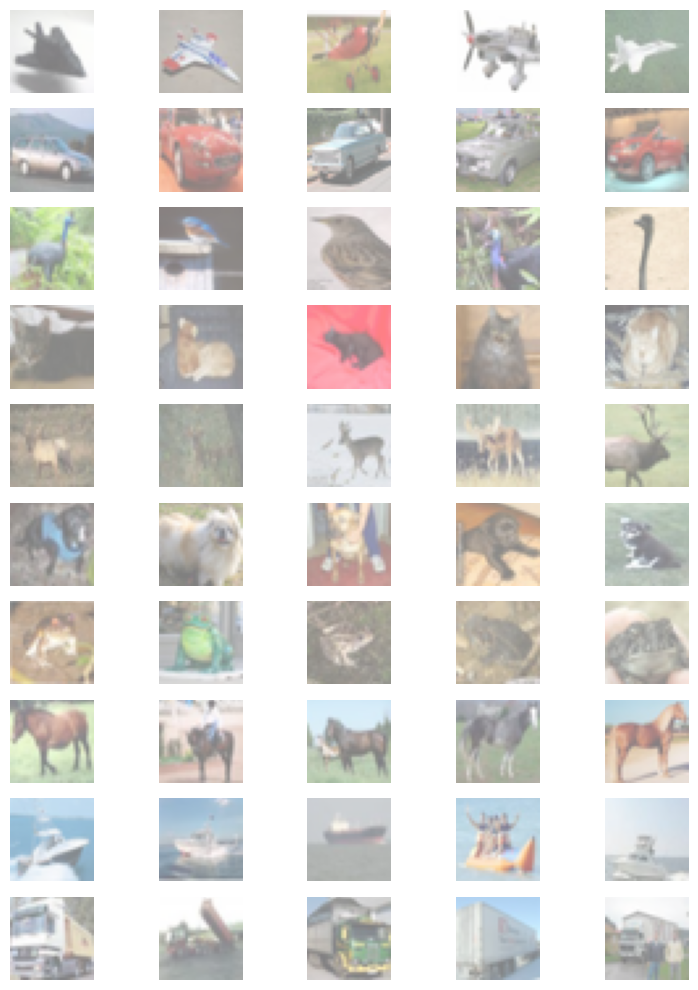

In [7]:
plot_random_images_per_class(trainset, classes, num_images=5)

# 3. Design Model

### 3.1. model architecture

In [8]:
class resnet(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
        self.fc = nn.Linear(512, num_cls)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc(x)
        return logits


# Initialize model and move to device
model = resnet(len(classes))
model = model.to(device)

### 3.2. set network parameter

In [10]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 50

# 4. Finetune model  

### 4.1. train phase

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/50: Training Loss: 1.5307 Accuracy: 0.4501
Epoch 2/50: Training Loss: 1.1327 Accuracy: 0.5990
Epoch 3/50: Training Loss: 0.9250 Accuracy: 0.6755
Epoch 4/50: Training Loss: 0.7690 Accuracy: 0.7313
Epoch 5/50: Training Loss: 0.6433 Accuracy: 0.7716
Epoch 6/50: Training Loss: 0.5311 Accuracy: 0.8113
Epoch 7/50: Training Loss: 0.4423 Accuracy: 0.8444
Epoch 8/50: Training Loss: 0.3675 Accuracy: 0.8693
Epoch 9/50: Training Loss: 0.2951 Accuracy: 0.8959
Epoch 10/50: Training Loss: 0.2346 Accuracy: 0.9170
Epoch 11/50: Training Loss: 0.1952 Accuracy: 0.9309
Epoch 12/50: Training Loss: 0.1694 Accuracy: 0.9397
Epoch 13/50: Training Loss: 0.1370 Accuracy: 0.9512
Epoch 14/50: Training Loss: 0.1090 Accuracy: 0.9605
Epoch 15/50: Training Loss: 0.0978 Accuracy: 0.9655
Epoch 16/50: Training Loss: 0.0873 Accuracy: 0.9695
Epoch 17/50: Training Loss: 0.0788 Accuracy: 0.9720
Epoch 18/50: Training Loss: 0.0629 Accuracy: 0.9776
Epoch 19/50: Training Loss: 0.0554 Accuracy: 0.9806
Epoch 20/50: Training

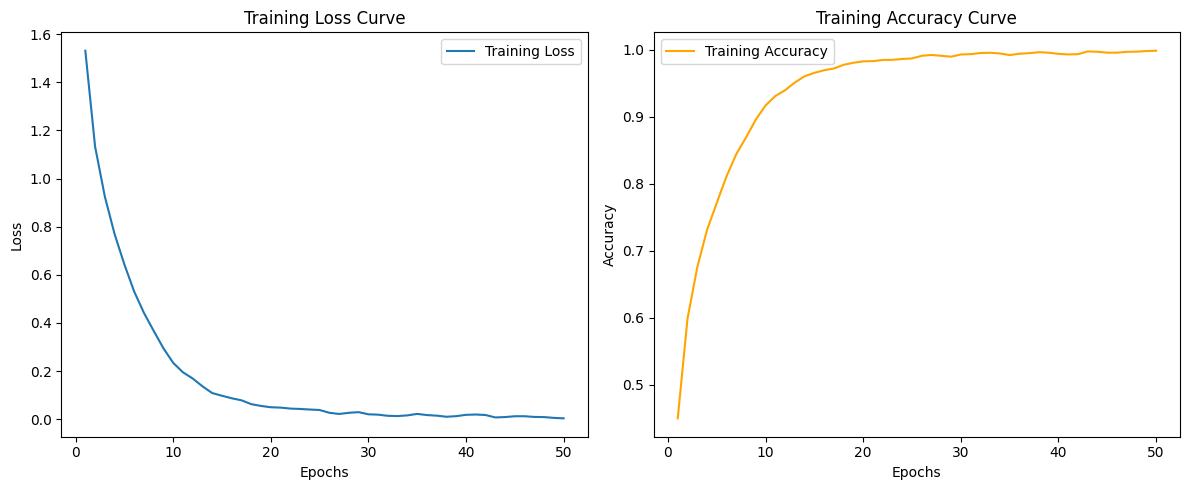

In [11]:
train_losses = []
train_accuracies = []

# Train phase
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader) # Initialize model and move to device
    epoch_accuracy = correct_predictions / total_predictions

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}: Training Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f}')

# Save the model weights
torch.save(model.state_dict(), 'model/model_weights.pth')
print('Model weights saved to model_weights.pth')


plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

### 4.2. Evaluation phase

In [12]:
# Evaluate the trained model on test set and print test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy : {test_accuracy}%')

Test Accuracy : 74.7%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


# 5. Adversarial Attack with FGSM method

### 5.1. attack with FGSM with different epsilon

Accuracy of the model on FGSM attack with epsilon = 0/255: 74.70%
Accuracy of the model on FGSM attack with epsilon = 2/255: 38.03%
Accuracy of the model on FGSM attack with epsilon = 4/255: 23.01%
Accuracy of the model on FGSM attack with epsilon = 6/255: 15.90%
Accuracy of the model on FGSM attack with epsilon = 8/255: 11.54%
Accuracy of the model on FGSM attack with epsilon = 10/255: 8.96%
Accuracy of the model on FGSM attack with epsilon = 12/255: 7.25%
Accuracy of the model on FGSM attack with epsilon = 14/255: 6.23%
Accuracy of the model on FGSM attack with epsilon = 16/255: 5.50%


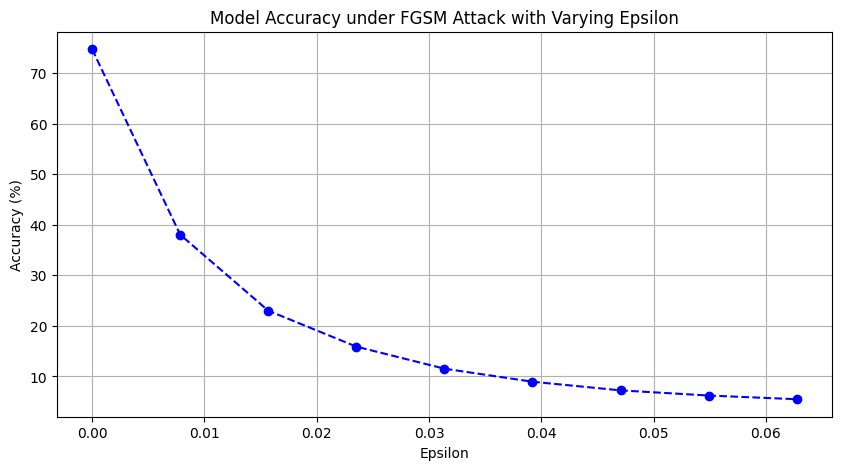

In [13]:
# Define the range of epsilons to test
epsilons = [0/255, 2/255, 4/255, 6/255, 8/255, 10/255, 12/255, 14/255, 16/255]
accuracies = []

model.eval()
for eps in epsilons:
    atk = torchattacks.FGSM(model, eps=eps)
    total = 0
    correct = 0
    with torch.enable_grad():
        for data, target in testloader:
            data = data.to(device)
            target = target.to(device)

            adv_images = atk(data, target)
            outputs = model(adv_images)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f'Accuracy of the model on FGSM attack with epsilon = {int(eps*255)}/255: {accuracy:.2f}%')


plt.figure(figsize=(10, 5))
plt.plot(epsilons, accuracies, marker='o', linestyle='--', color='b')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy under FGSM Attack with Varying Epsilon')
plt.grid(True)
plt.show()

### 5.2. design a function for plot original images and perturbed images

In [14]:
import random

def plot_original_and_perturbed(model, images, labels, perturbed_images_list, epsilons):
    num_images = len(images)
    num_epsilons = len(epsilons)
    plt.figure(figsize=(15, 5 * (num_epsilons + 1)))

    # Plot the original images
    for i in range(num_images):
        image = images[i].cpu().squeeze().permute(1, 2, 0).numpy()
        label = labels[i]

        plt.subplot(num_epsilons + 1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Original\nTrue: {classes[label]}")
        plt.axis('off')

    # Plot the perturbed images for each epsilon
    for j, (perturbed_images, epsilon) in enumerate(zip(perturbed_images_list, epsilons)):
        for i in range(num_images):
            perturbed_image = perturbed_images[i].cpu().squeeze().permute(1, 2, 0).numpy()

            with torch.no_grad():
                perturbed_output = model(perturbed_images[i].unsqueeze(0).to(device))
                _, perturbed_pred = torch.max(perturbed_output, 1)

            plt.subplot(num_epsilons + 1, num_images, (j + 1) * num_images + i + 1)
            plt.imshow(perturbed_image)
            plt.title(f"Perturbed\nPred: {classes[perturbed_pred.item()]}\n(ε={epsilon:.3f})")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

### 5.3. test network with FGSM attack

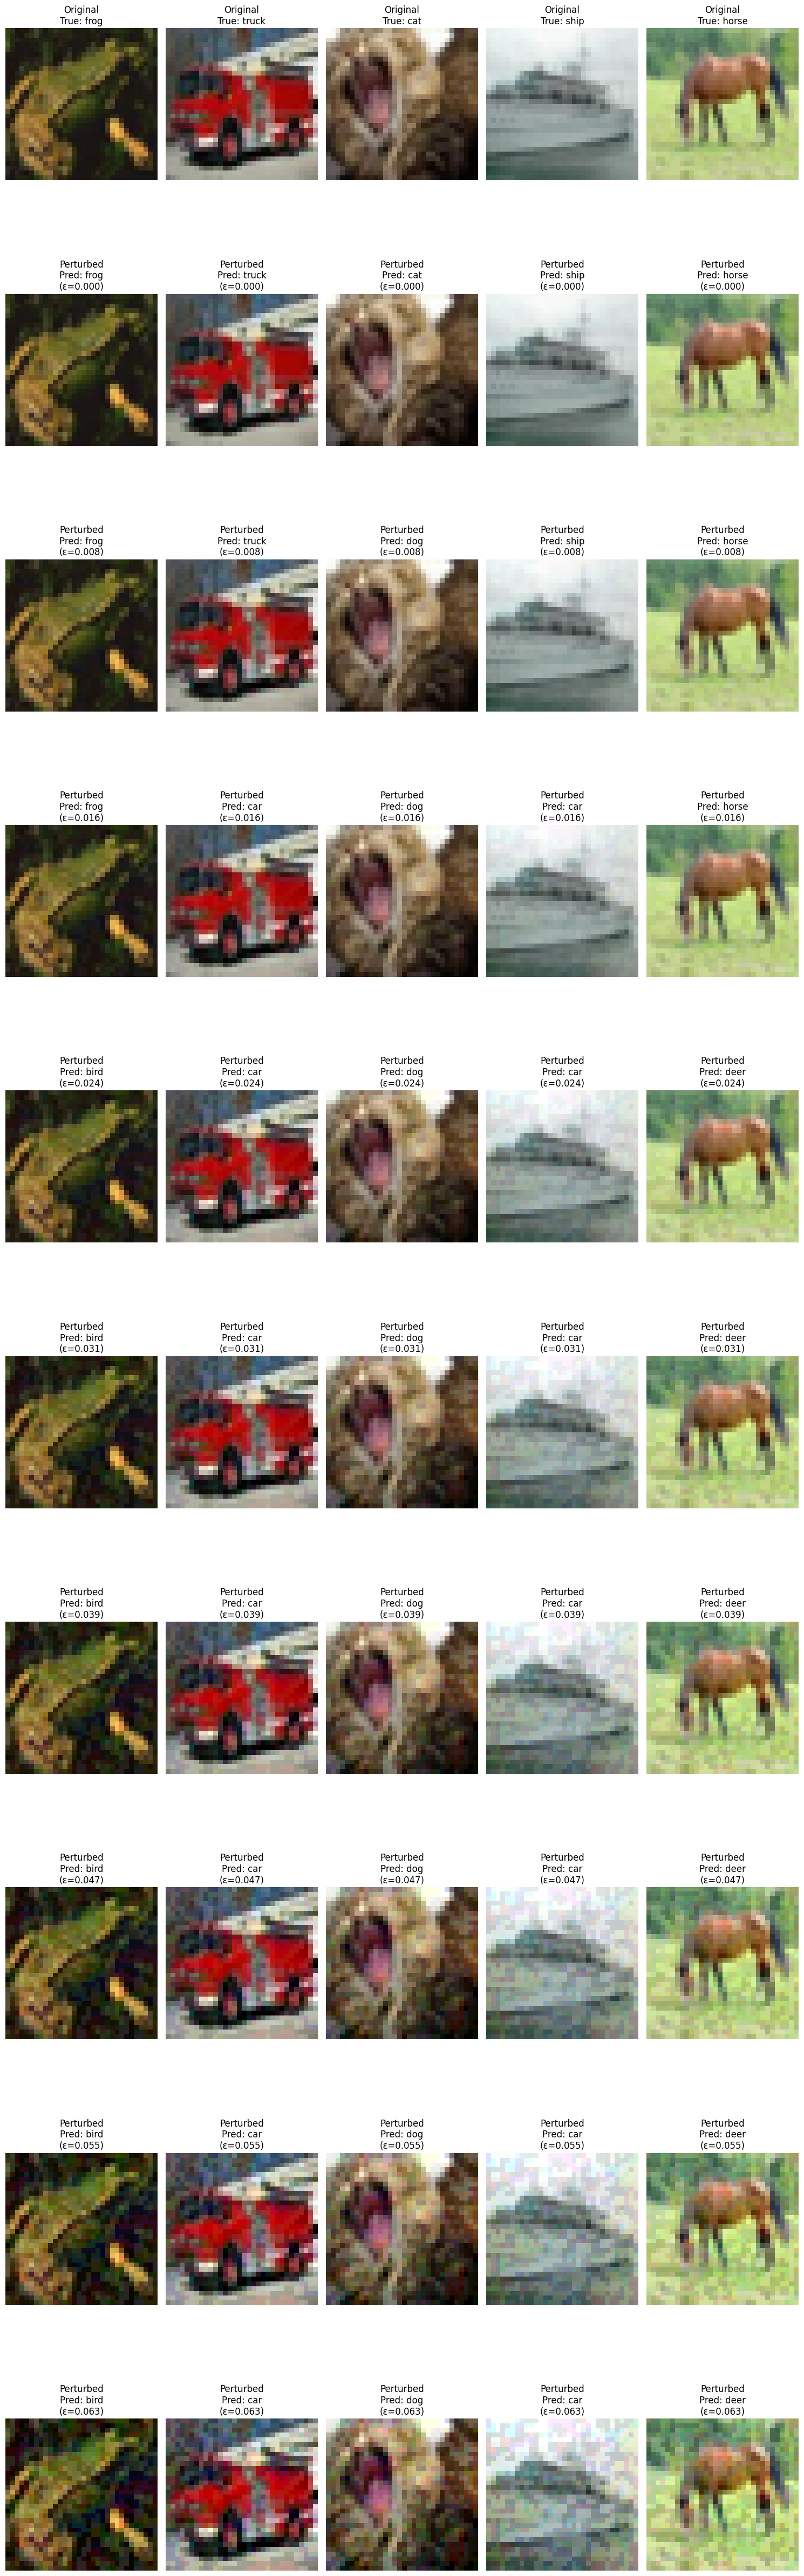

In [16]:
# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)

# Select 5 random images from the test set
random_indices = random.sample(range(len(images)), 5)
selected_images = [images[idx] for idx in random_indices]
selected_labels = [labels[idx].item() for idx in random_indices]

model.eval()

perturbed_images_list = []
for eps in epsilons:
    atk = torchattacks.FGSM(model, eps=eps)
    perturbed_images = []
    for idx in random_indices:
        image = images[idx].unsqueeze(0).to(device)
        label = labels[idx].unsqueeze(0).to(device)

        perturbed_image = atk(image, label)
        perturbed_images.append(perturbed_image.squeeze().cpu())

    perturbed_images_list.append(perturbed_images)

# Plot the original and perturbed images
plot_original_and_perturbed(model, selected_images, selected_labels, perturbed_images_list, epsilons)

# 6. Adversarial Training

### 6.1. re-train network (adversarial training)

Epoch 1/100: Loss: 2.1359 Accuracy: 0.2107
Epoch 2/100: Loss: 1.9971 Accuracy: 0.2532
Epoch 3/100: Loss: 1.9290 Accuracy: 0.2787
Epoch 4/100: Loss: 1.8823 Accuracy: 0.2956
Epoch 5/100: Loss: 1.8411 Accuracy: 0.3075
Epoch 6/100: Loss: 1.8036 Accuracy: 0.3206
Epoch 7/100: Loss: 1.7694 Accuracy: 0.3299
Epoch 8/100: Loss: 1.7350 Accuracy: 0.3424
Epoch 9/100: Loss: 1.7062 Accuracy: 0.3486
Epoch 10/100: Loss: 1.6755 Accuracy: 0.3590
Epoch 11/100: Loss: 1.6396 Accuracy: 0.3687
Epoch 12/100: Loss: 1.6095 Accuracy: 0.3777
Epoch 13/100: Loss: 1.5727 Accuracy: 0.3867
Epoch 14/100: Loss: 1.5325 Accuracy: 0.3979
Epoch 15/100: Loss: 1.4923 Accuracy: 0.4113
Epoch 16/100: Loss: 1.4573 Accuracy: 0.4215
Epoch 17/100: Loss: 1.4152 Accuracy: 0.4344
Epoch 18/100: Loss: 1.3801 Accuracy: 0.4441
Epoch 19/100: Loss: 1.3349 Accuracy: 0.4578
Epoch 20/100: Loss: 1.2961 Accuracy: 0.4723
Epoch 21/100: Loss: 1.2553 Accuracy: 0.4857
Epoch 22/100: Loss: 1.2141 Accuracy: 0.4997
Epoch 23/100: Loss: 1.1741 Accuracy: 0.51

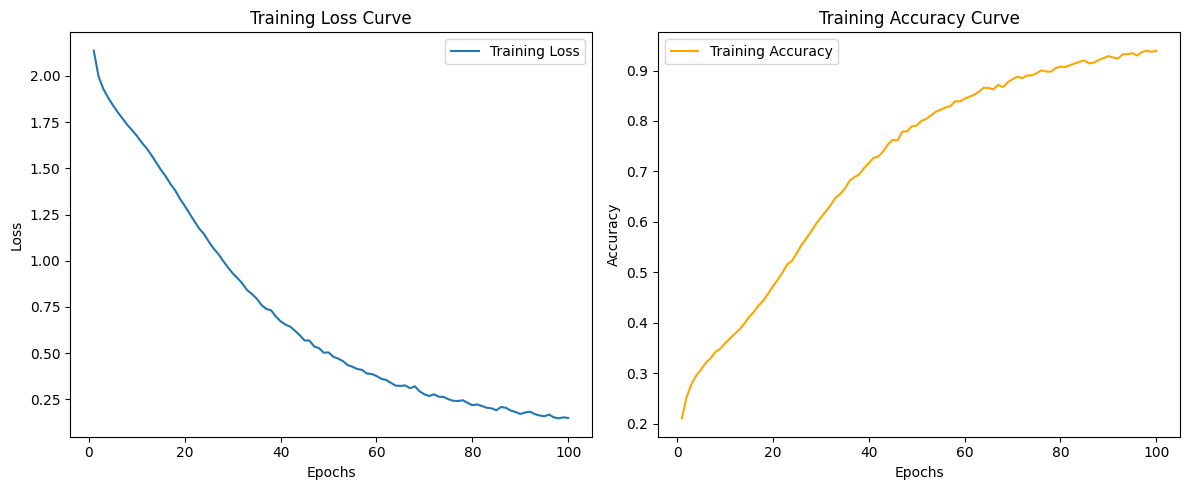

In [17]:
adv_model = resnet(len(classes))
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

adv_model.train()
atk = torchattacks.FGSM(adv_model, eps=8/255)

train_losses = []
train_accuracies = []


for epoch in range(epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)

        perturbed_data = atk(data, target)

        optimizer.zero_grad()
        outputs = adv_model(perturbed_data)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct_predictions / total_predictions

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}: Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f}')

# Save the model weights
torch.save(adv_model.state_dict(), 'model/adv_model_weights.pth')
print('Model weights saved to adv_model_weights.pth')

# Plot the loss and accuracy learning curves
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

### 6.2. test accuracy on adversarial model

In [18]:
adv_model.eval()
correct = 0
total = 0
with torch.enable_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = adv_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy on Adversarial Model: {test_accuracy}%')

Test Accuracy on Adversarial Model: 61.24%


### 6.3. attack with FGSM with different epsilon on adversarial model

Accuracy of the adv_model on FGSM attack with epsilon = 0/255: 61.24%
Accuracy of the adv_model on FGSM attack with epsilon = 2/255: 48.02%
Accuracy of the adv_model on FGSM attack with epsilon = 4/255: 37.77%
Accuracy of the adv_model on FGSM attack with epsilon = 6/255: 29.92%
Accuracy of the adv_model on FGSM attack with epsilon = 8/255: 24.04%
Accuracy of the adv_model on FGSM attack with epsilon = 10/255: 19.48%
Accuracy of the adv_model on FGSM attack with epsilon = 12/255: 16.41%
Accuracy of the adv_model on FGSM attack with epsilon = 14/255: 13.73%
Accuracy of the adv_model on FGSM attack with epsilon = 16/255: 11.97%


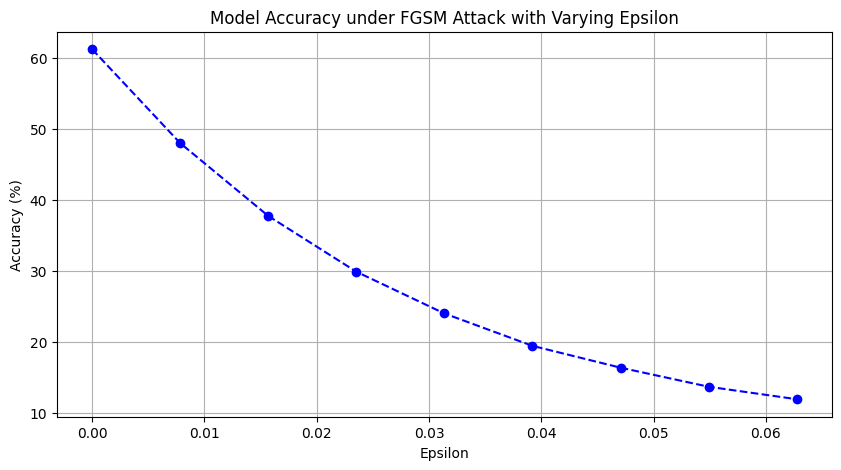

In [19]:
# Define the range of epsilons to test
epsilons = [0/255, 2/255, 4/255, 6/255, 8/255, 10/255, 12/255, 14/255, 16/255]
accuracies = []

adv_model.eval()
for eps in epsilons:
    atk = torchattacks.FGSM(adv_model, eps=eps)
    total = 0
    correct = 0
    with torch.enable_grad():
        for data, target in testloader:
            data = data.to(device)
            target = target.to(device)

            adv_images = atk(data, target)
            outputs = adv_model(adv_images)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f'Accuracy of the adv_model on FGSM attack with epsilon = {int(eps*255)}/255: {accuracy:.2f}%')


plt.figure(figsize=(10, 5))
plt.plot(epsilons, accuracies, marker='o', linestyle='--', color='b')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy under FGSM Attack with Varying Epsilon')
plt.grid(True)
plt.show()

### 6.4. test adversarial model with FGSM attack

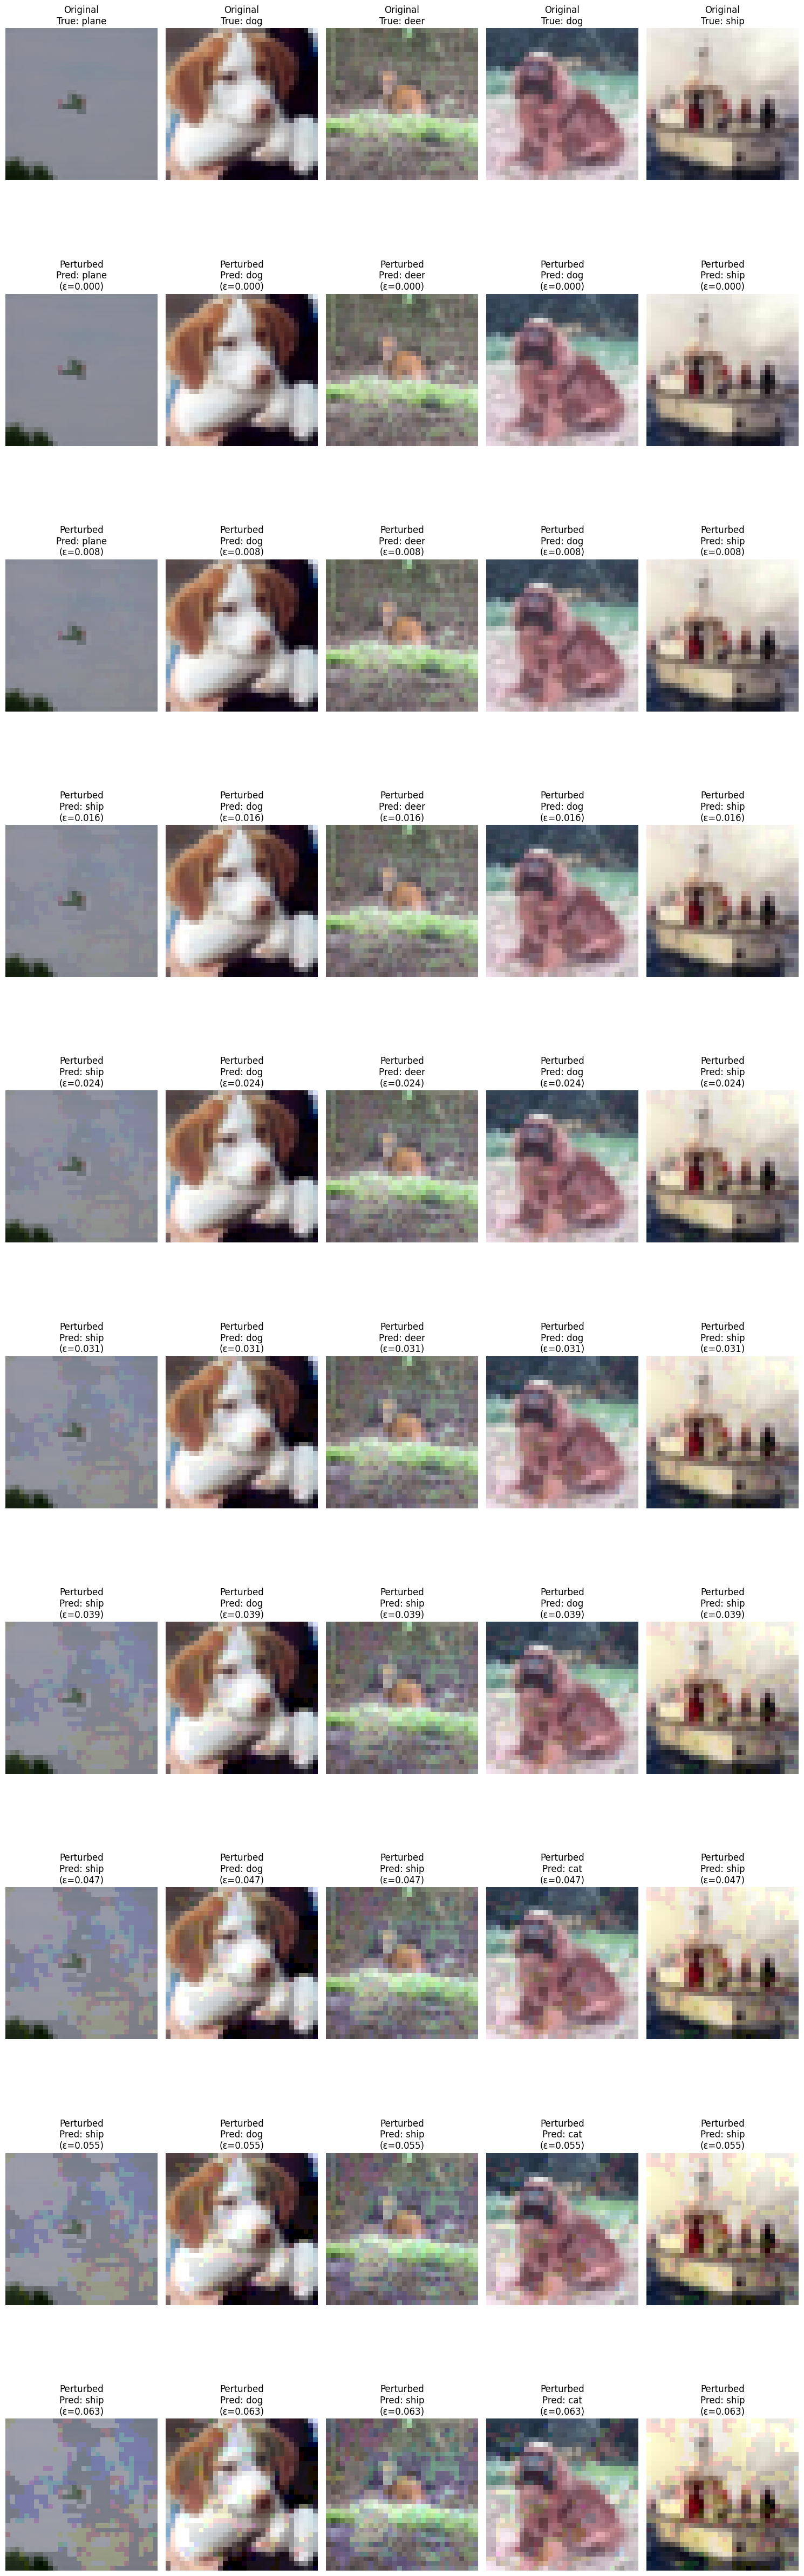

In [24]:
# Get a batch of test data
dataiter = iter(testloader)
images, labels = next(dataiter)

# Select 5 random images from the test set
random_indices = random.sample(range(len(images)), 5)
selected_images = [images[idx] for idx in random_indices]
selected_labels = [labels[idx].item() for idx in random_indices]

adv_model.eval()

perturbed_images_list = []
for eps in epsilons:
    atk = torchattacks.FGSM(adv_model, eps=eps)
    perturbed_images = []
    for idx in random_indices:
        image = images[idx].unsqueeze(0).to(device)
        label = labels[idx].unsqueeze(0).to(device)

        perturbed_image = atk(image, label)
        perturbed_images.append(perturbed_image.squeeze().cpu())

    perturbed_images_list.append(perturbed_images)

# Plot the original and perturbed images
plot_original_and_perturbed(model, selected_images, selected_labels, perturbed_images_list, epsilons)